In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,auc,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
data.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin',
       ...
       'discharge_disposition_id_7', 'discharge_disposition_id_9',
       'discharge_disposition_id_10', 'discharge_disposition_id_13',
       'discharge_disposition_id_18', 'discharge_disposition_id_28',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other'],
      dtype='object', length=101)

In [4]:
data.readmitted.value_counts()

0    65222
1     6293
Name: readmitted, dtype: int64

In [5]:
X = data.drop('readmitted',axis=1)
y = data['readmitted']

In [6]:
y.value_counts()

0    65222
1     6293
Name: readmitted, dtype: int64

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    model[1].fit(X_train, y_train)
    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_opti_cutoff'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test, = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [8]:
X_train,X_test,y_train,y_test = train_test_resampled_split(X,y,info=True,test_size=0.1,sampling_type='up_sampling',down_sampling_type='nearmiss')

Before sampling Counter({0: 65222, 1: 6293})
After SMOTE up sampling Counter({0: 65222, 1: 27952})
--------------------------------------------------


In [9]:
X_train,X_test,y_train,y_test = train_test_resampled_split(X,y,info=True,test_size=0.1,sampling_type='hybrid',down_sampling_type='nearmiss')

Before sampling Counter({0: 65222, 1: 6293})
After nearmiss down sampling Counter({0: 35660, 1: 6293})
After SMOTE up sampling Counter({0: 35660, 1: 15282})
--------------------------------------------------


In [10]:
import statsmodels.api as sm

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             readmitted   No. Observations:                45847
Model:                            GLM   Df Residuals:                    45750
Model Family:                Binomial   Df Model:                           96
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14617.
Date:                Mon, 24 Aug 2020   Deviance:                       29234.
Time:                        13:35:29   Pearson chi2:                 4.29e+04
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.7472      0.107     16.262      0.000       1.537       1.958
gender                         -0.3183      0.031    -10.258      0.000      -0.379      -0.257
age                             0.0197      0.024      0.823      0.410      -0.027       0.067
time_in_hospital                0.1517      0.022      6.987      0.000       0.109       0.194
num_lab_procedures              0.0077      0.001      7.602      0.000       0.006       0.010
num_procedures                  0.1549      0.011     13.846      0.000       0.133       0.177
num_medications                 0.0489      0.003     16.029      0.000       0.043       0.055
number_diagnoses               -0.1004      0.053     -1.877      0.061      -0.205       0.004
max_glu_serum                   0.3225      0.129      2.504      0.012       0.070       0.575
A1Cresult                      -0.0130      0.053     -0.246      0.806      -0.117       0.091
metformin                      -1.0653      0.063    -16.919      0.000      -1.189      -0.942
repaglinide                    -0.5362      0.146     -3.666      0.000      -0.823      -0.250
nateglinide                    -1.2834      0.240     -5.356      0.000      -1.753      -0.814
chlorpropamide                 -1.5038      0.673     -2.236      0.025      -2.822      -0.185
glimepiride                    -0.9790      0.094    -10.457      0.000      -1.163      -0.796
acetohexamide               -1.464e-09   1.11e-06     -0.001      0.999   -2.17e-06    2.17e-06
glipizide                      -0.9812      0.066    -14.854      0.000      -1.111      -0.852
glyburide                      -0.9204      0.069    -13.425      0.000      -1.055      -0.786
tolbutamide                    -1.5512      1.098     -1.413      0.158      -3.703       0.600
pioglitazone                   -1.1054      0.084    -13.181      0.000      -1.270      -0.941
rosiglitazone                  -0.9218      0.086    -10.695      0.000      -1.091      -0.753
acarbose                       -0.6424      0.373     -1.724      0.085      -1.373       0.088
miglitol                       -3.1696      1.590     -1.993      0.046      -6.287      -0.052
troglitazone                  -21.5369   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
tolazamide                     -2.2301      1.118     -1.995      0.046      -4.421      -0.039
insulin                        -0.9065      0.047    -19.210      0.000      -0.999      -0.814
glyburide-metformin            -1.0427      0.224     -4.659      0.000      -1.481      -0.604
glipizide-metformin           -25.1716   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
glimepiride-pioglitazone    -1.263e-09   1.21e-06     -0.001      0.999   -2.36e-06    2.36e-06
metformin-r

In [11]:
#Backward Elimination
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    model = sm.GLM(y_train,(sm.add_constant(X_1)), family = sm.families.Binomial()).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['gender', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'number_of_revisit', 'critical_visits', 'num_med_change', 'admission_source_id_4', 'admission_source_id_7', 'admission_type_id_3', 'diag_1_1.0', 'diag_1_2.0', 'diag_1_3.0', 'diag_1_4.0', 'diag_1_5.0', 'diag_1_6.0', 'diag_1_7.0', 'diag_1_8.0', 'diag_1_9.0', 'diag_1_10.0', 'diag_1_11.0', 'diag_1_12.0', 'diag_1_13.0', 'diag_1_14.0', 'diag_1_16.0', 'diag_1_17.0', 'diag_2_1.0', 'diag_2_2.0', 'diag_2_3.0', 'diag_2_4.0', 'diag_2_5.0', 'diag_2_6.0', 'diag_2_7.0', 'diag_2_8.0', 'diag_2_9.0', 'diag_2_10.0', 'diag_2_11.0', 'diag_2_12.0', 'diag_2_13.0', 'diag_2_14.0', 'diag_2_16.0', 'diag_2_17.0', 'diag_3_1.0', 'diag_3_2.0', 'diag_3_3.0', 'diag_3_4.0', 'diag_3_5.0', 'diag_3_6.

In [12]:
cols_to_be_removed = [i for i in data.columns if i not in selected_features_BE + ['readmitted']]

In [13]:
new_data = data.drop(cols_to_be_removed,axis=1)

In [14]:
cols_to_be_removed

['age',
 'number_diagnoses',
 'A1Cresult',
 'acetohexamide',
 'tolbutamide',
 'acarbose',
 'troglitazone',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'admission_source_id_9',
 'admission_source_id_12',
 'admission_type_id_5',
 'diag_3_14.0',
 'discharge_disposition_id_9',
 'discharge_disposition_id_18',
 'race_Hispanic',
 'race_Other']

In [15]:
len(new_data.columns)

82

In [16]:
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [17]:
vif_df = vif_cal(input_data=new_data, dependent_col='readmitted')

In [18]:
vif_df

,Var,Vif
23,num_med_change,44.24
33,diag_1_7.0,13.20
49,diag_2_7.0,10.39
20,diabetesMed,9.61
4,num_medications,8.27
...,...,...
15,miglitol,1.01
16,tolazamide,1.01
75,discharge_disposition_id_7,1.01
78,discharge_disposition_id_28,1.01


In [19]:
high_vif_features = vif_df[vif_df['Vif']>9]['Var'].values

In [20]:
high_vif_features

array(['num_med_change', 'diag_1_7.0', 'diag_2_7.0', 'diabetesMed'],
      dtype=object)

In [21]:
new_data = new_data.drop(high_vif_features,axis=1)

In [22]:
new_data.shape

(71515, 78)

In [23]:
new_data.to_csv('final_data.csv',index=False)

In [24]:
X = new_data.drop('readmitted',axis=1)
y = new_data['readmitted']

## Base Models

- Logistic Regression
- KNN classifier
- Naive Bayes Classifier
- Decision Tree Classifier
- Random Forest Classifier

### Logistic Regression

Logistic Regression
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.833432  0.626064   0.775345  0.871962
2     2.0  0.846592  0.644401   0.805237  0.884833
3     3.0  0.835230  0.646174   0.767677  0.874109
4     4.0  0.834445  0.622629   0.780968  0.880771
5     5.0  0.837583  0.616743   0.795781  0.875707
6     6.0  0.836378  0.630648   0.781656  0.875787
7     7.0  0.840699  0.637852   0.790584  0.884385
8     8.0  0.841289  0.647020   0.785998  0.882040
9     9.0  0.839521  0.631303   0.791461  0.877407
10   10.0  0.843056  0.637197   0.798851  0.875209

Average accuracy after k-fold = 0.8388224159450608
Average recall after k-fold = 0.6340032028672473
Average precision after k-fold = 0.7873558024099958
Average ROC_AUC after k-fold = 0.8782210581737591
---------------------

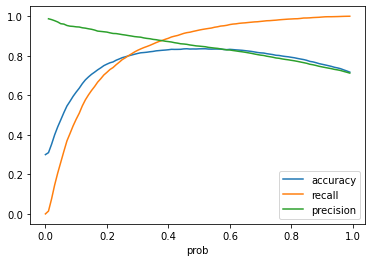

Optimum cutoff probability is 0.38
Accuracy is 0.83
Precision is 0.71
Recall is 0.71
ROC_AUC Score is 0.79

Classification report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5349
           1       0.71      0.71      0.71      2293

    accuracy                           0.83      7642
   macro avg       0.80      0.79      0.79      7642
weighted avg       0.83      0.83      0.83      7642

confusion matrix 

 [[4694  655]
 [ 661 1632]]


In [25]:
from sklearn.linear_model import LogisticRegression
lr = ['Logistic Regression',LogisticRegression()]
model_check(lr,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

### K-Nearest Neighbor

K-Nearest Neighbor
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.728933  0.620825   0.542024  0.748275
2     2.0  0.730308  0.622135   0.544101  0.755701
3     3.0  0.726559  0.640288   0.537027  0.764344
4     4.0  0.724402  0.625245   0.534676  0.762453
5     5.0  0.723421  0.625245   0.533185  0.760463
6     6.0  0.715380  0.631958   0.521058  0.749415
7     7.0  0.727362  0.631958   0.538805  0.758351
8     8.0  0.732076  0.616241   0.547411  0.762723
9     9.0  0.715380  0.599869   0.522235  0.751609
10   10.0  0.715380  0.608382   0.521910  0.743285

Average accuracy after k-fold = 0.7239202381698209
Average recall after k-fold = 0.6222146983252833
Average precision after k-fold = 0.534243165813967
Average ROC_AUC after k-fold = 0.7556615933112663
-----------------------

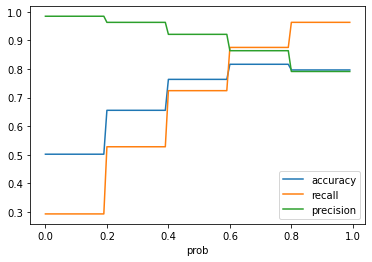

Optimum cutoff probability is 0.60
Accuracy is 0.82
Precision is 0.70
Recall is 0.68
ROC_AUC Score is 0.78

Classification report
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      5349
           1       0.70      0.68      0.69      2293

    accuracy                           0.82      7642
   macro avg       0.78      0.78      0.78      7642
weighted avg       0.82      0.82      0.82      7642

confusion matrix 

 [[4684  665]
 [ 736 1557]]


In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = ['K-Nearest Neighbor',KNeighborsClassifier()]
model_check(knn,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

### Naive Bayes

Naive Bayes
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.542330  0.851343   0.382016  0.801140
2     2.0  0.605971  0.848723   0.422012  0.814778
3     3.0  0.553747  0.865271   0.390035  0.810504
4     4.0  0.591016  0.828646   0.410032  0.811252
5     5.0  0.602982  0.833878   0.418719  0.804217
6     6.0  0.594775  0.833661   0.413043  0.805201
7     7.0  0.611668  0.856582   0.426614  0.821876
8     8.0  0.604989  0.844139   0.420967  0.812216
9     9.0  0.601061  0.844139   0.418235  0.810358
10   10.0  0.594579  0.819253   0.411649  0.795173

Average accuracy after k-fold = 0.5903116438912999
Average recall after k-fold = 0.8425634844865668
Average precision after k-fold = 0.41133233229231986
Average ROC_AUC after k-fold = 0.8086714502154517
----------------------------

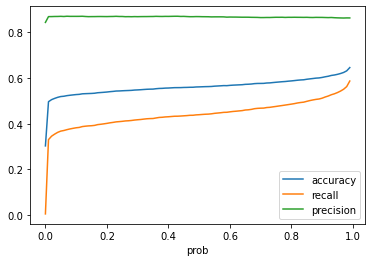

Optimum cutoff probability is 0.99
Accuracy is 0.65
Precision is 0.45
Recall is 0.78
ROC_AUC Score is 0.69

Classification report
               precision    recall  f1-score   support

           0       0.86      0.59      0.70      5349
           1       0.45      0.78      0.57      2293

    accuracy                           0.65      7642
   macro avg       0.66      0.69      0.63      7642
weighted avg       0.74      0.65      0.66      7642

confusion matrix 

 [[3140 2209]
 [ 497 1796]]


In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = ['Naive Bayes',GaussianNB()]
model_check(gnb,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

### Decision Tree

Decision Tree
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.779611  0.638507   0.631068  0.739287
2     2.0  0.792772  0.656843   0.653846  0.753927
3     3.0  0.785798  0.650098   0.640877  0.747016
4     4.0  0.792075  0.655984   0.652570  0.753181
5     5.0  0.770302  0.610203   0.618700  0.724547
6     6.0  0.763308  0.596595   0.607333  0.715665
7     7.0  0.776272  0.618206   0.629333  0.731101
8     8.0  0.789629  0.647675   0.649803  0.749341
9     9.0  0.787468  0.652259   0.643827  0.748829
10   10.0  0.765665  0.605763   0.610158  0.719969

Average accuracy after k-fold = 0.7802899777983424
Average recall after k-fold = 0.6332133221802626
Average precision after k-fold = 0.6337515805769491
Average ROC_AUC after k-fold = 0.7382862195202343
---------------------------

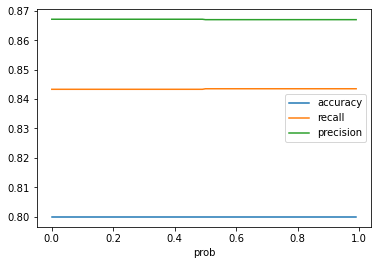

Optimum cutoff probability is 0.50
Accuracy is 0.80
Precision is 0.66
Recall is 0.70
ROC_AUC Score is 0.77

Classification report
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      5349
           1       0.66      0.70      0.68      2293

    accuracy                           0.80      7642
   macro avg       0.76      0.77      0.77      7642
weighted avg       0.80      0.80      0.80      7642

confusion matrix 

 [[4512  837]
 [ 692 1601]]


In [28]:
from sklearn.tree import DecisionTreeClassifier
dtc = ['Decision Tree',DecisionTreeClassifier()]
model_check(dtc,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

### Random Forest Classifier

Random Forest
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.846003  0.628029   0.816170  0.883774
2     2.0  0.857788  0.647675   0.841702  0.900876
3     3.0  0.849157  0.646174   0.812500  0.896898
4     4.0  0.856610  0.649444   0.835859  0.897035
5     5.0  0.846607  0.624591   0.821152  0.894733
6     6.0  0.844824  0.616896   0.821273  0.891156
7     7.0  0.850717  0.618206   0.842105  0.890604
8     8.0  0.859949  0.642436   0.854530  0.908841
9     9.0  0.863877  0.657498   0.855196  0.898517
10   10.0  0.846396  0.614276   0.829355  0.887293

Average accuracy after k-fold = 0.8521927594901086
Average recall after k-fold = 0.6345225659086948
Average precision after k-fold = 0.8329841349467552
Average ROC_AUC after k-fold = 0.8949727084302838
---------------------------

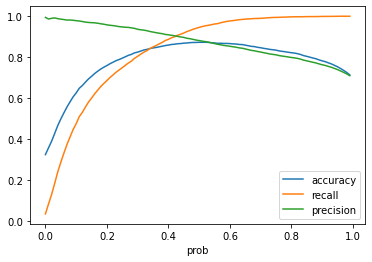

Optimum cutoff probability is 0.43
Accuracy is 0.87
Precision is 0.78
Recall is 0.77
ROC_AUC Score is 0.84

Classification report
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      5349
           1       0.78      0.77      0.77      2293

    accuracy                           0.87      7642
   macro avg       0.84      0.84      0.84      7642
weighted avg       0.87      0.87      0.87      7642

confusion matrix 

 [[4852  497]
 [ 530 1763]]


In [29]:
from sklearn.ensemble import RandomForestClassifier
rfr = ['Random Forest',RandomForestClassifier(criterion = "gini",random_state = 5)]
model_check(rfr,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

In [30]:
result

,Accuracy,Precision,Recall,AUC_ROC
Logistic Regression,0.838822,0.787356,0.634003,0.878221
K-Nearest Neighbor,0.723920,0.534243,0.622215,0.755662
Naive Bayes,0.590312,0.411332,0.842563,0.808671
Decision Tree,0.780290,0.633752,0.633213,0.738286
Random Forest,0.852193,0.832984,0.634523,0.894973


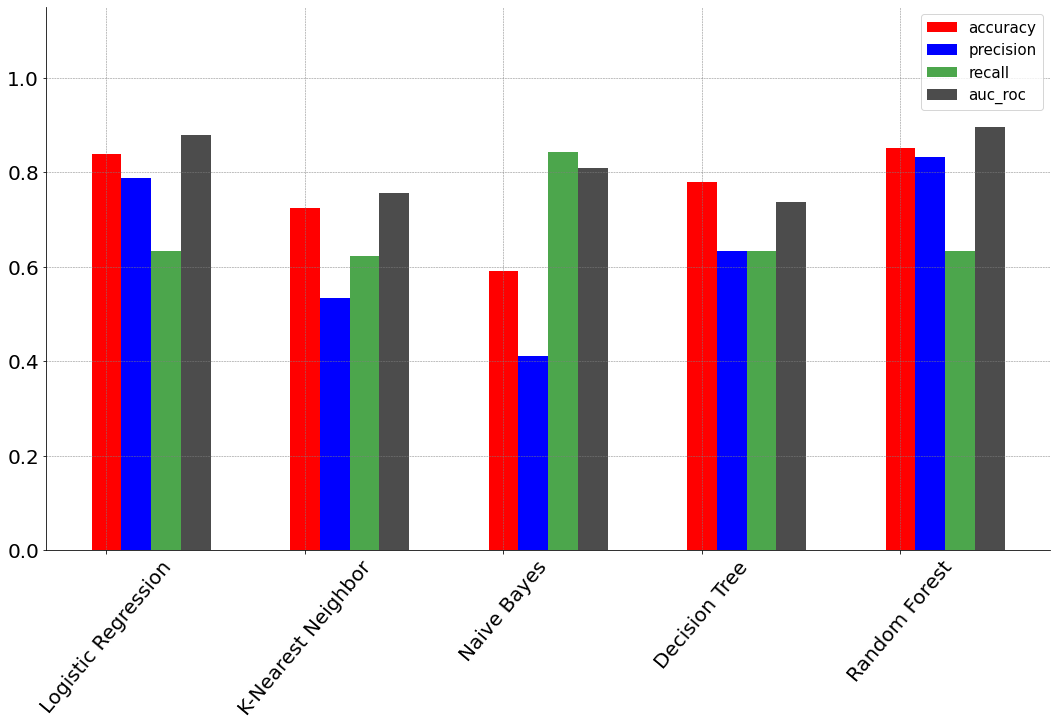

In [102]:
plt.figure(figsize=(18, 10))

ax = plt.subplot(111)

models = result.index
values = list(result['Accuracy'])
model = np.arange(len(result))

plt.bar(model, values, align='center', width = 0.15, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Precision'])
model = np.arange(len(result))

plt.bar(model+0.15, values, align='center', width = 0.15, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Recall'])
model = np.arange(len(result))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['AUC_ROC'])
model = np.arange(len(result))

plt.bar(model+0.45, values, align='center', width = 0.15, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=20)
plt.yticks(size=20)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 15})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

In [32]:
result_for_optimized

,Accuracy,Precision,Recall,AUC_ROC
Logistic Regression_opti_cutoff,0.827794,0.713599,0.711731,0.794639
K-Nearest Neighbor_opti_cutoff,0.816671,0.700720,0.679023,0.777350
Naive Bayes_opti_cutoff,0.645904,0.448439,0.783253,0.685139
Decision Tree_opti_cutoff,0.799921,0.656686,0.698212,0.770867
Random Forest_opti_cutoff,0.865611,0.780088,0.768862,0.837974


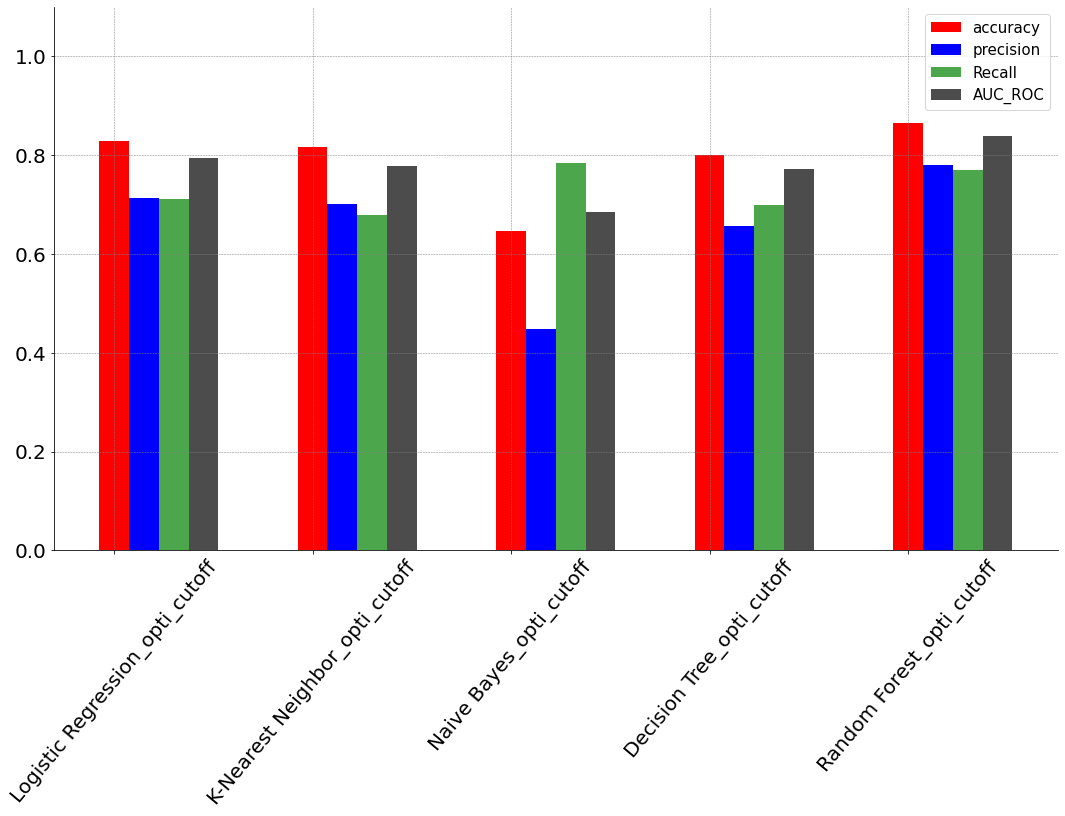

In [101]:
plt.figure(figsize=(18, 10))

ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Accuracy'])
model = np.arange(len(result_for_optimized))

plt.bar(model, values, align='center', width = 0.15, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Precision'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.15, values, align='center', width = 0.15, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Recall'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'Green', label= 'Recall')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['AUC_ROC'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.45, values, align='center', width = 0.15, alpha=0.7, color = 'black', label= 'AUC_ROC')
plt.xticks(model, models,rotation=50,size=20)
plt.yticks(size=20)
ax.set_ylim(top=1.1)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 15})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')
plt.show() 